<a href="https://colab.research.google.com/github/tariqshaban/suicide-detection/blob/master/Suicide%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
# Display generic output messages
!pip install colorama

# Huggingface related libraries
!pip install transformers datasets evaluate

# Download assets from the GitHub repository
!apt install subversion
!svn checkout https://github.com/tariqshaban/suicide-detection/trunk/assets

import json
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import urllib
import tensorflow as tf

from colorama import Fore, Back, Style

from datasets import Dataset
from datasets import DatasetDict
from datasets import load_dataset

from IPython.display import Image, display, clear_output

from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import History, EarlyStopping

from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import pipeline
from transformers import TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback

from typing import Dict


# Acquire the dataset from its LFS source

# Obtain LFS file metadata
with open('assets/dataset/Suicide_Detection.csv') as file:
    lines = [line.rstrip() for line in file]
sha = lines[1][lines[1].index(':')+1:]
size = lines[2][lines[2].index(' ')+1:]

# Acquire direct download link
payload =  f'''
{{
    "operation": "download", 
    "transfer": ["basic"], 
    "objects": [
        {{"oid": "{sha}", "size": {size}}}
    ]
}}
'''
curl = f'''
curl -X POST \
-H 'Accept: application/vnd.git-lfs+json' \
-H 'Content-type: application/json' \
-d '{payload}' \
https://github.com/tariqshaban/suicide-detection.git/info/lfs/objects/batch
'''
response = json.loads(os.popen(curl).read())
file_url = response['objects'][0]['actions']['download']['href']

# Replace LFS metadata with the actual file
!rm assets/dataset/Suicide_Detection.csv
urllib.request.urlretrieve(file_url, 'assets/dataset/Suicide_Detection.csv')


clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

✓ Successfully downloaded dependencies.



# Defining Constants

In [2]:
DATASET_FILENAME = './assets/dataset/Suicide_Detection.csv'
PLOTS_OUTPUT = './assets/output/images'
MODEL_OUTPUT = './assets/output/model'

ID2LABEL = {0: 'non-suicide', 1: 'suicide'}
LABEL2ID = {'non-suicide': 0, 'suicide': 1}

LABELS = list(LABEL2ID.keys())

SAMPLE_FRACTION = 1

VALIDATION_SIZE = 0.01
TEST_SIZE = 0.005

BATCH_SIZE = 2
EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30
EARLY_STOPPING_MIN_DELTA = 0.001

# Helper Methods

### Get Tokenizor

In [3]:
def get_tokenizer() -> any:
    """
    Fetches the distilbert-base-uncased tokenizer.

    :return: The tokenizer
    """

    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    return tokenizer

### Get Pretrained Model

In [4]:
def get_pretrained_model() -> any:
    """
    Fetches the distilbert-base-uncased pre-trained model, based on the ID2LABEL and LABEL2ID.

    :return: The pre-trained model
    """

    model = TFAutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=2, id2label=ID2LABEL, label2id=LABEL2ID
    )

    return model

### Get Trained Model Pipeline

In [5]:
def get_trained_pipeline() -> any:
    """
    Returns a pipeline from the trained model; based on the MODEL_OUTPUTD.

    :return: The trained model
    """

    trained_pipeline = pipeline('sentiment-analysis', model=MODEL_OUTPUT, tokenizer=MODEL_OUTPUT)

    return trained_pipeline

### Prime Dataset

In [6]:
def prime_dataset(
        tokenizer: any,
) -> [DatasetDict, pd.DataFrame]:
    """
    Ready the dataset for training.

    :param any tokenizer: The tokenizer object
    :return: The processed dataset
    """

    def preprocess_function(
            examples: any,
    ) -> any:
        """
        Converts the label of the dataset to a numerical ID; and tokenizes the text.

        :param any examples: The batched examples
        :return: The processed examples
        """

        examples['label'] = [LABEL2ID.get(e, e) for e in examples['label']]
        return tokenizer(examples['text'], truncation=True)

    df = pd.read_csv(DATASET_FILENAME)
    df = df.sample(frac=SAMPLE_FRACTION)

    df_train_valid = df.sample(frac=1 - TEST_SIZE)
    df_test = df.drop(df_train_valid.index)

    suicide_detection = Dataset.from_pandas(df_train_valid)

    suicide_detection = suicide_detection.rename_column('class', 'label')
    suicide_detection = suicide_detection.remove_columns('Unnamed: 0')
    suicide_detection = suicide_detection.train_test_split(test_size=VALIDATION_SIZE / (1 - TEST_SIZE))

    tokenized_suicide_detection = suicide_detection.map(preprocess_function, batched=True)

    return [tokenized_suicide_detection, df_test]

### Visualize Model Results

In [7]:
def visualize_model(
        test_dataset: pd.DataFrame,
        fitted_model: History,
):
    """
    Display plots based on the trained model.

    :param pd.DataFrame test_dataset: The dataset to test on
    :param History fitted_model: The trained model
    """

    trained_pipeline = get_trained_pipeline()

    plt.plot(fitted_model.history['loss'])
    plt.plot(fitted_model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig(f'{PLOTS_OUTPUT}/loss_history.png')
    plt.show()

    y_predict = [prediction['label'] for prediction in
                 trained_pipeline(test_dataset['text'].to_list(), truncation=True, max_length=4096)]
    y_true = test_dataset['class'].to_list()

    ax = sns.heatmap(confusion_matrix(y_true, y_predict, labels=LABELS), annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(LABELS)
    ax.yaxis.set_ticklabels(LABELS)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig(f'{PLOTS_OUTPUT}/confusion_matrix.png')
    plt.show()

### Train Model

In [8]:
def train_model(
        tokenizer: any,
        tokenized_dataset: DatasetDict,
        test_dataset: pd.DataFrame,
        visualize: bool = True,
        export_model: bool = True,
):
    """
    Trains the model.

    :param any tokenizer: The embedding's tokenizer
    :param DatasetDict tokenized_dataset: The preprocessed training dataset
    :param pd.DataFrame test_dataset: The testing dataset
    :param bool visualize: Whether to show visualizations or not
    :param bool export_model: Whether to export the model or not
    """

    def compute_metrics(
        eval_pred: any,
    ) -> dict:
        """
        Computes a custom prediction for the training.

        :param any eval_pred: An object containing the prediction and actual value
        :return: The computed metric for the example
        """

        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return accuracy.compute(predictions=predictions, references=labels)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

    accuracy = evaluate.load('accuracy')

    batches_per_epoch = len(tokenized_dataset['train'])
    total_train_steps = int(batches_per_epoch * EPOCHS)
    optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

    model = get_pretrained_model()

    train_set = model.prepare_tf_dataset(
        tokenized_dataset['train'],
        shuffle=True,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    validation_set = model.prepare_tf_dataset(
        tokenized_dataset['test'],
        shuffle=False,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    model.compile(optimizer=optimizer)

    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=EARLY_STOPPING_PATIENCE, min_delta=EARLY_STOPPING_MIN_DELTA)

    metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=validation_set)

    callbacks = [es, metric_callback]

    fitted_model = model.fit(x=train_set, validation_data=validation_set, epochs=EPOCHS, callbacks=callbacks)

    loss = model.evaluate(validation_set)

    print(Fore.GREEN + u'\n\u2713 ' + f'Loss ==> {loss}')
    print(Fore.RESET)

    model.summary()

    if export_model:
        tokenizer.save_pretrained(MODEL_OUTPUT)
        model.save_pretrained(MODEL_OUTPUT)

    if visualize:
        visualize_model(test_dataset=test_dataset, fitted_model=fitted_model)

# Methods Invocation

In [9]:
!mkdir -p  $PLOTS_OUTPUT
!mkdir -p  $MODEL_OUTPUT

The syntax of the command is incorrect.
The syntax of the command is incorrect.


Map:   0%|          | 0/228593 [00:00<?, ? examples/s]

Map:   0%|          | 0/2321 [00:00<?, ? examples/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/300
114296/114296 [==============================] - 11382s 100ms/step - loss: 0.1015 - val_loss: 0.0850 - accuracy: 0.9716
Epoch 2/300
114296/114296 [==============================] - 10805s 95ms/step - loss: 0.0735 - val_loss: 0.1294 - accuracy: 0.9703
Epoch 3/300
114296/114296 [==============================] - 9856s 86ms/step - loss: 0.0646 - val_loss: 0.0921 - accuracy: 0.9681
Epoch 4/300
114296/114296 [==============================] - 10010s 88ms/step - loss: 0.0595 - val_loss: 0.1337 - accuracy: 0.9655
Epoch 5/300
114296/114296 [==============================] - 9798s 86ms/step - loss: 0.0638 - val_loss: 0.0992 - accuracy: 0.9668
Epoch 6/300
114296/114296 [==============================] - 9785s 86ms/step - loss: 0.0613 - val_loss: 0.1066 - accuracy: 0.9638
Epoch 7/300
114296/114296 [==============================] - 9791s 86ms/step - loss: 0.0603 - val_loss: 0.1348 - accuracy: 0.9586
Epoch 8/300
114296/114296 [==============================] - 9983s 87ms/step - loss: 0

Some layers from the model checkpoint at ./assets/output/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./assets/output/model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


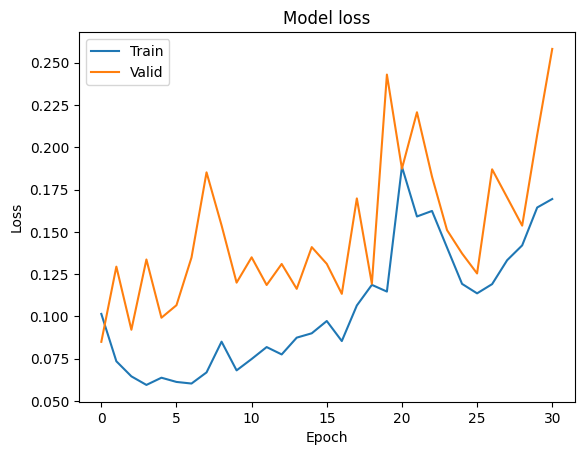

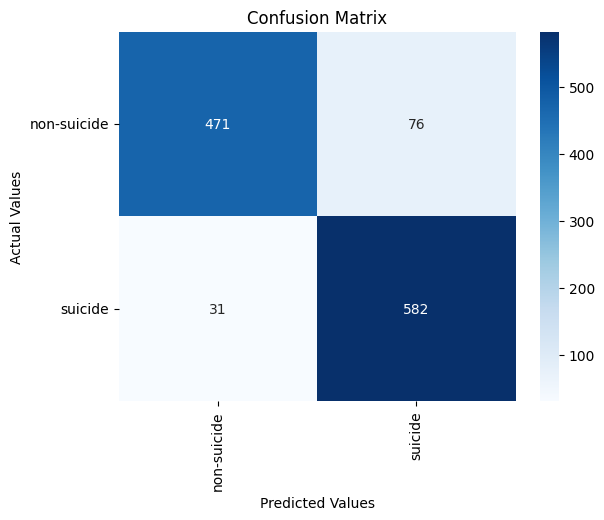

In [10]:
tokenizer = get_tokenizer()

tokenized_dataset, test_dataset = prime_dataset(tokenizer=tokenizer)

model = train_model(tokenizer=tokenizer, tokenized_dataset=tokenized_dataset, test_dataset=test_dataset)

In [11]:
trained_pipeline = get_trained_pipeline()

Some layers from the model checkpoint at ./assets/output/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./assets/output/model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
text = 'This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three.'
trained_pipeline(text, truncation=True, max_length=4096)

[{'label': 'non-suicide', 'score': 0.6055302619934082}]

In [13]:
text = 'I am severly depressed'
trained_pipeline(text, truncation=True, max_length=4096)

[{'label': 'suicide', 'score': 0.7709288001060486}]